In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import timedelta

In [35]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from flask import Flask, render_template, jsonify

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

session = Session(engine)
# reflect the tables
print("Reflected tables:", Base.classes.keys())

Reflected tables: ['measurement', 'station']


C:\Users\Saint\AppData\Local\Temp\ipykernel_5504\3996243148.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print("Reflected tables (classes):")
for table_name in Base.classes.keys():
    print(table_name)

Reflected tables (classes):
measurement
station


In [8]:
# Save references to each table
tables = {table_name: getattr(Base.classes, table_name) for table_name in Base.classes.keys()}
tables

{'measurement': sqlalchemy.ext.automap.measurement,
 'station': sqlalchemy.ext.automap.station}

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
if 'measurement' in Base.classes:
    Measurement = Base.classes.measurement

    print(Measurement)

<class 'sqlalchemy.ext.automap.measurement'>


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
with Session(engine) as session:
        most_recent_date = session.query(func.max(Measurement.date)).scalar()
        print("Most recent date:", most_recent_date)

Most recent date: 2017-08-23


Most recent date: 2017-08-23 00:00:00
One year ago: 2016-08-23 00:00:00


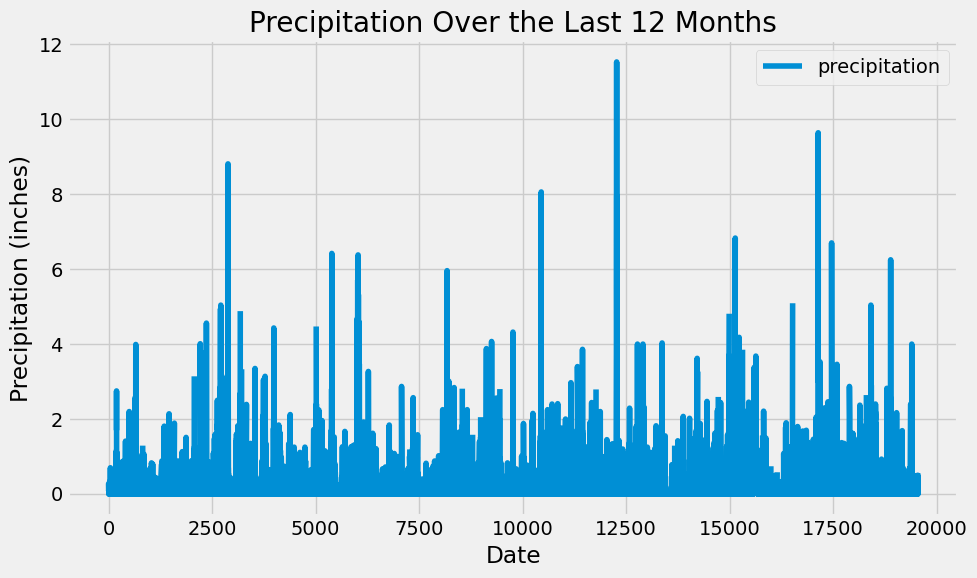

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
if isinstance(most_recent_date, str):
    most_recent_date = pd.to_datetime(most_recent_date)
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)
print("Most recent date:", most_recent_date)
print("One year ago:", one_year_ago)
# Perform a query to retrieve the data and precipitation scores
results = session.query(
    Measurement.date,
    Measurement.prcp
).order_by(Measurement.date).all()
    

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df['precipitation'].plot(
    figsize=(10, 6),  
    title="Precipitation Over the Last 12 Months",  
    xlabel="Date",  
    ylabel="Precipitation (inches)",  
    legend=True  
)
plt.grid(True) 
plt.tight_layout()  
plt.show()

In [13]:
session.query(
    Measurement.date,
    Measurement.prcp
).order_by(Measurement.date).all()

[('2010-01-01', 0.08),
 ('2010-01-01', 0.28),
 ('2010-01-01', 0.21),
 ('2010-01-01', 0.15),
 ('2010-01-01', 0.15),
 ('2010-01-01', 0.05),
 ('2010-01-01', 0.14),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.02),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.01),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-05', 0.0),
 ('2010-01-05', 0.02),
 ('2010-01-05', 0.01),
 ('2010-01-05', 0.0),
 ('2010-01-05', 0.0),
 ('2010-01-05', 0.0),
 ('2010-01-06', None),
 ('2010-01-06', 0.02),
 ('2010-01-06', 0.11),
 ('2010-01-06', 0.01),
 ('2010-01-06', 0.08),
 ('2010-01-06', 0.36),
 ('2010-01-07', 0.06),
 ('2010-01-07', 0.38),
 ('2010-01-07', None),
 ('2010-01-07', 0.7),
 ('2010-01-0

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
print(summary_stats)

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Measurement.station))).scalar()
print(f"Total number of distinct stations: {total_stations}")

Total number of distinct stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station,  
    func.count(Measurement.station).label('station_count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()) 
  

if active_stations:
    most_active_station = active_stations[0]  
    station_id = most_active_station.station
    station_count = most_active_station.station_count
    print(f"The most active station is {station_id} with {station_count} rows.")
else:
    print("No stations found.")


The most active station is USC00519281 with 2772 rows.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).filter(Measurement.station == 'USC00519281').first()
active_station_id = most_active_station[0]


In [18]:
temperature_stats = session.query(
    func.min(Measurement.tobs).label('lowest_temp'),
    func.max(Measurement.tobs).label('highest_temp'),
    func.avg(Measurement.tobs).label('average_temp')
).filter(
    Measurement.station == active_station_id  
).all()  

if temperature_stats:
    for lowest, highest, average in temperature_stats:
            print(f"Most Active Station: {active_station_id}")
            print(f"Lowest Temperature: {lowest}°F")
            print(f"Highest Temperature: {highest}°F")
            print(f"Average Temperature: {average:.2f}°F")


Most Active Station: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


In [19]:
most_active_station
print()

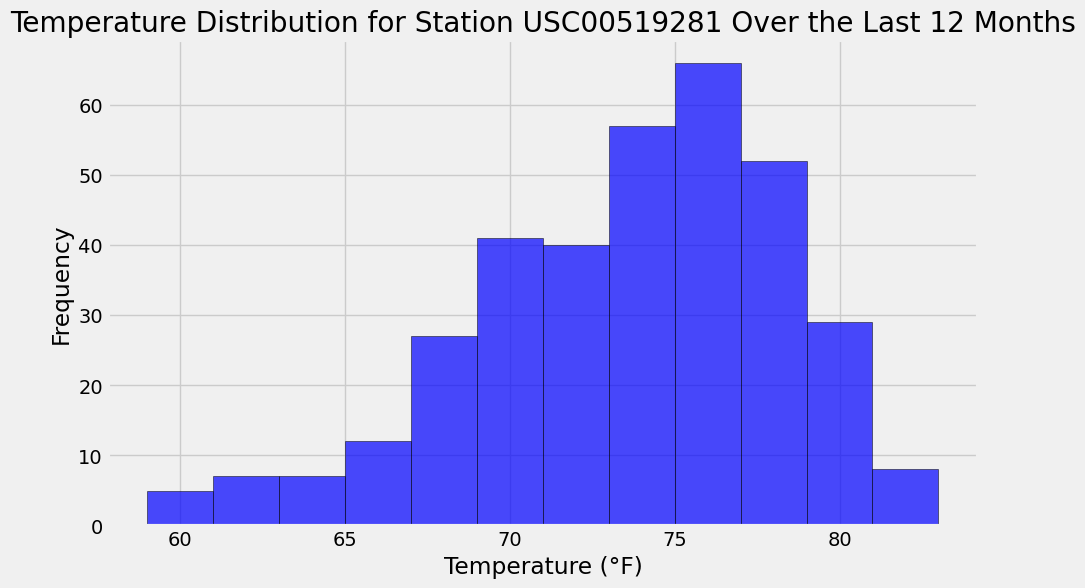

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = most_recent_date - timedelta(days=365)

temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == active_station_id,
    Measurement.date >= start_date,
    Measurement.date <= most_recent_date
).all()

df = pd.DataFrame(temperature_data, columns=['Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(df['Temperature'], bins=12, color='blue', edgecolor='black', alpha=0.7)
plt.title(f"Temperature Distribution for Station {active_station_id} Over the Last 12 Months")
plt.xlabel("Temperature (°F)")  
plt.ylabel("Frequency")
plt.grid(True)


# Close Session

In [21]:
# Close Session
session.close()